In [1]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
warnings.filterwarnings("ignore", message=r"Implicit", category=UserWarning)
warnings.filterwarnings("ignore", message=r"cannot", category=UserWarning)

In [2]:
import os
import sys
sys.path.append('..')

from carla.recourse_methods import Dice, Wachter
from copy import deepcopy
from model_shifts import (DynamicCsvCatalog,
                          RecourseExperiment,
                          RecourseGenerator,
                          train_model,
                          plot_experiment,
                          generate_gif)

os.environ["CUDA_VISIBLE_DEVICES"] = ""

#     torch.manual_seed(0)
#     random.seed(0)
#     np.random.seed(0)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:
# Load the dataset from a csv file
dataset = DynamicCsvCatalog(file_path="../datasets/unimodal_dataset_4.csv", 
                            continuous=['feature1', 'feature2'], categorical=[],
                            immutables=[], target='target', test_size=0.3)

[INFO] Balance: train set 0.5, test set 0.5 [dynamic_csv_catalog.py __init__]


In [5]:
hyper_params = {'learning_rate': 0.04, 'epochs': 2, 'batch_size': 1, 'hidden_size': [4]}

# Recourse generated by DICE is compared with the Wachter generator, as they may modify data differently
# we need to keep track of two models and two datasets and update them independently
model = train_model(dataset, hyper_params)

generators = [
              RecourseGenerator('DICE_1', deepcopy(dataset), deepcopy(model),
                                Dice, {"num": 1}, hyper_params, 60),
              RecourseGenerator('DICE_2', deepcopy(dataset), deepcopy(model),
                                Dice, {"num": 2}, hyper_params, 30),
              RecourseGenerator('Wachter', deepcopy(dataset), deepcopy(model),
                                Wachter, {"loss_type": "BCE"}, hyper_params, 30)
             ]

# SET NAME BEFORE THE EXPERIMENT
name='600_words_experiment'
experiment = RecourseExperiment(dataset, model, generators, name)
experiment.run(epochs=3, recourse_per_epoch=10)
experiment.save_data()

[INFO] Training the initial model [recourse_generator.py train_model]


TypeError: 'list' object is not callable

In [5]:
experiment_path = f'../experiment_data/{experiment.experiment_name}'
for g in generators:
    generate_gif(experiment_path, g.name)

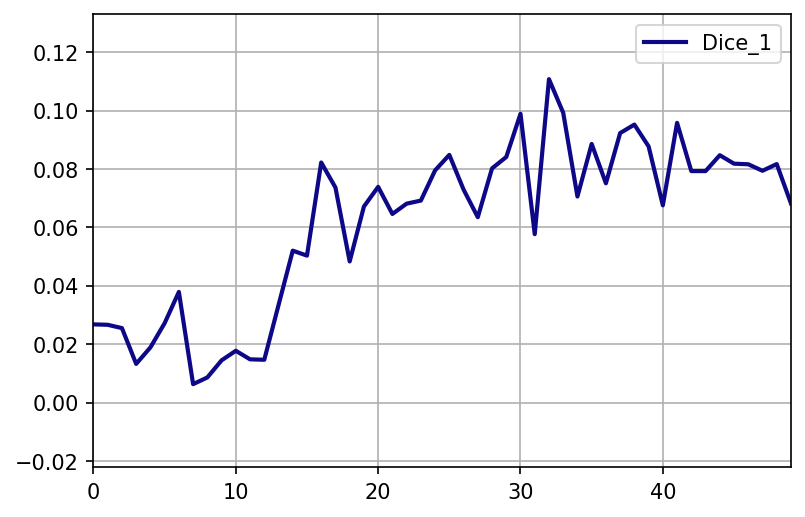

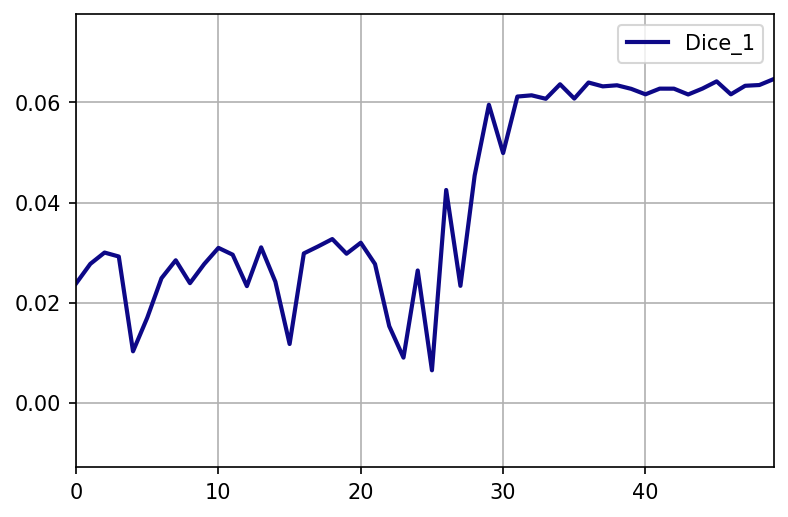

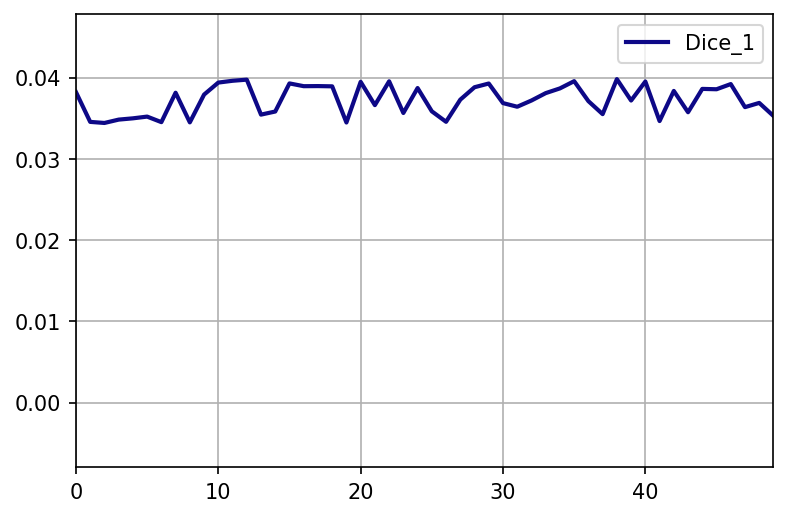

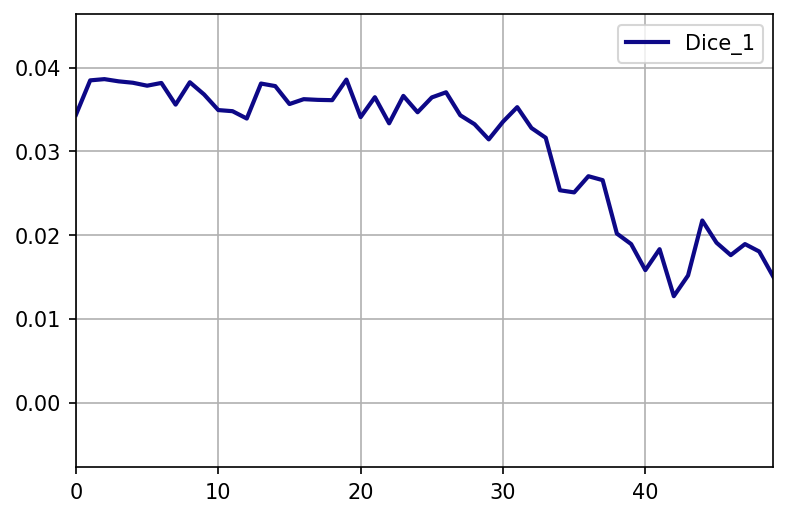

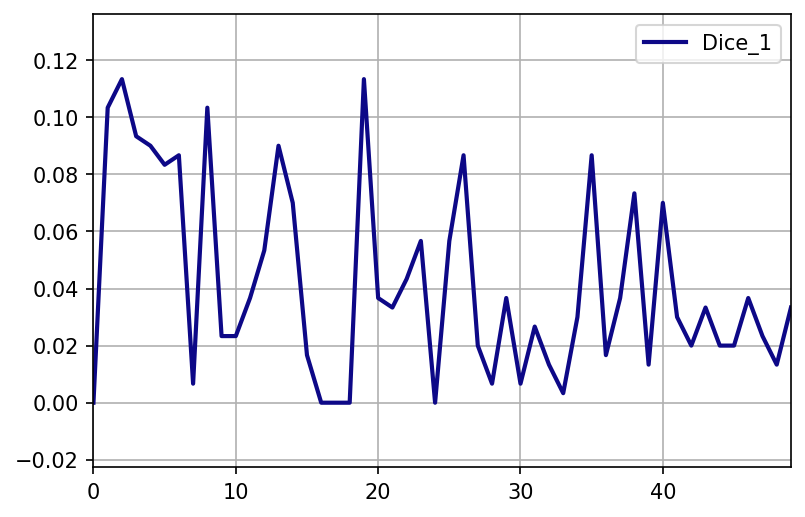

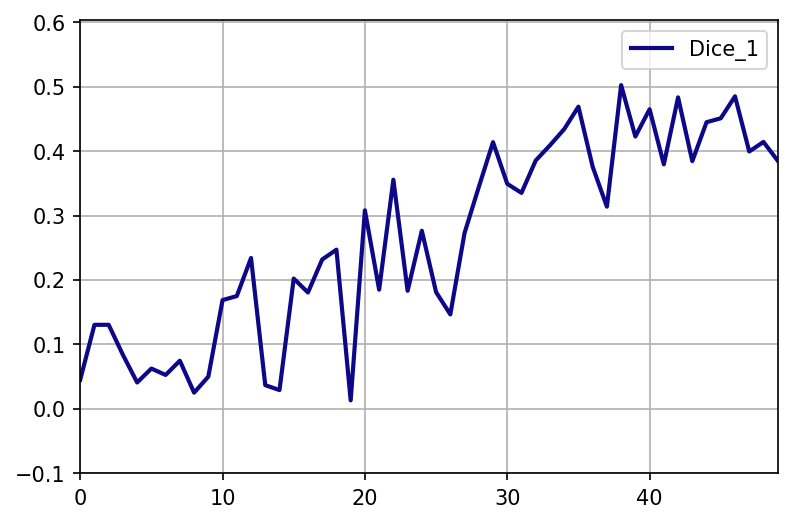

In [28]:
config = [
    {'type': 'pos_MMD', 'dict_path': ['MMD', 'positive', 'value']},
    {'type': 'neg_MMD', 'dict_path': ['MMD', 'negative', 'value']},
    {'type': 'pos_distance', 'dict_path': ['boundary_distance', 'positive']},
    {'type': 'neg_distance', 'dict_path': ['boundary_distance', 'negative']},
    {'type': 'disagreement', 'dict_path': ['disagreement']},
    {'type': 'model_MMD', 'dict_path': ['model_MMD', 'value']}
]

for c in config:
    plot_experiment(experiment_path,
                    [g.name for g in generators],
                    c['type'],
                    c['dict_path'],
                    show_plot=False)